### Stupid Baseline Solution

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import random
import torch

In [ ]:
train_on_gpu = torch.cuda.is_available()

In [ ]:
data = pd.read_csv('df_three.csv',sep = ';')

In [ ]:
data = data.fillna('0')

In [ ]:
Libra = data['Весы'].values

In [ ]:
TEXT_START = 0
TEXT_END = -1 # если захотим не все тексты
text = Libra[TEXT_START : TEXT_END]

In [ ]:
texts = [t.lower() for t in text]
text = ''.join(text).lower()

In [ ]:
len(text.split())

23444

**Dataset cleaning**

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
stop = set(nltk.corpus.stopwords.words('russian'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()

**N-Gram Language Modeling**


In [ ]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['благоприятный', 'день'], 'общения'), (['день', 'общения'], 'удается'), (['общения', 'удается'], 'произвести')]


In [ ]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [ ]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

**GRU model for Text Generation**

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [ ]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
n_epochs = 500
print_every = 10
plot_every = 10
hidden_size = 100
n_layers = 2
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
decoder = decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 31s (10 1%) 6.0528]
 1s (20 2%) 3.0115]
 28s (30 3%) 0.9062]
 56s (40 4%) 0.1892]
 26s (50 5%) 0.0457]
 52s (60 6%) 0.0173]
 24s (70 7%) 0.0093]
 54s (80 8%) 0.0064]
 28s (90 9%) 0.0050]
 0s (100 10%) 0.0042]
 29s (110 11%) 0.0036]
 56s (120 12%) 0.0032]
 26s (130 13%) 0.0029]
 1s (140 14%) 0.0027]
 34s (150 15%) 0.0025]
 5s (160 16%) 0.0023]
 35s (170 17%) 0.0021]
 6s (180 18%) 0.0020]
 39s (190 19%) 0.0018]
 7s (200 20%) 0.0017]
 38s (210 21%) 0.0016]
 9s (220 22%) 0.0015]
 36s (230 23%) 0.0014]
 6s (240 24%) 0.0014]
 38s (250 25%) 0.0013]
 8s (260 26%) 0.0012]
 36s (270 27%) 0.0012]
 7s (280 28%) 0.0011]
 39s (290 28%) 0.0011]
 7s (300 30%) 0.0010]
 39s (310 31%) 0.0010]
 10s (320 32%) 0.0009]
 42s (330 33%) 0.0009]
 15s (340 34%) 0.0009]
 47s (350 35%) 0.0008]
 18s (360 36%) 0.0008]
 45s (370 37%) 0.0008]
 9s (380 38%) 0.0007]
 33s (390 39%) 0.0007]
 55s (400 40%) 0.0007]
 22s (410 41%) 0.0007]
 53s (420 42%) 0.0006]
 27s (430 43%) 0.0006]
 56s (440 44%) 0.0006]
 28s (450 45%) 0.0

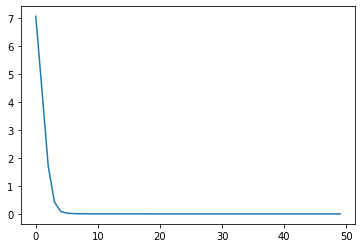

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

**Generating the text**

In [ ]:
def evaluate(prime_str='спокойный день', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:]
        output, hidden = decoder(inp, hidden)
        
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word

    return prime_str

In [ ]:
print(evaluate('спокойный день', 40, temperature=0.7))

спокойный день подходит того учиться чемуто новому собирать анализировать информацию размышлять наблюдательны многое замечаете делаете правильные выводы увиденного многим нравится ход ваших мыслей наверняка найдутся люди которые захотят узнать получше день начинается интересно идей планов немедленно возьметесь осуществление задуманного быстро добьетесь первых


In [ ]:
for i in range(15):
  print(evaluate(' '.join(x for x in trigrams[random.randint(0,len(trigrams))][0]), random.randint(15,30), temperature=0.7), '\n\n')

договориться совместных действиях планы удается сможете воплотить жизнь какието разногласия остаются прошлом никому хочется вспоминать старых обидах нелегко сохранять спокойствие особенно начале дня это время 


вечер подходит обсудить романтических отношений людьми которых хотите однако исключено полученная впечатление благодаря оно быстро добьетесь верные добиваетесь успехов там справились другие ваши достижения остаются незамеченными многие захотят узнать побольше будьте готовы 


задач справляетесь опасность тактично достаточно вашей подходящий день начала новых дел результаты которых добьетесь приятно удивят ваши идеи получают поддержку нужна помощь реализации просить дважды приходится легко находите общий язык новыми знакомыми 


вероятны хорошие новости касающиеся денег также выгодные сделки покупки возможность решить какойто вопрос важный вас ваших близких все делаете других сегодня идет 


сюрпризы это подходящее недоброжелателями свой самый дел находите деталям тем изза это в

In [ ]:
torch.save(decoder.state_dict(), 'base_model_500_epoch')